## Hebbian learning in feedforward networks.

Based on the code below, implement a number of experiments to investigate how Hebbian learning behaves when training neural networks.
To be able to evaluate how successful an approach is, we will be using a subset of the MNIST dataset to train on and evaluate the quality of the learned Hebbian features by using either a "majority-vote" readout or a linear regression to finish the classification problem (see below). Additionally, we can look at the weight vectors as images to get a sense of the quality of the learned, unsupervised features.

Note, that the network we are using is completely linear and has no biases. $y = W x$ where $y$ is the output and $x$ is the input.

Your job will be to implement the training of these features (on batches and for networks!), the rest of the code is provided.

For each of the variants below, discuss the outcomes for each of the evaluation steps. Use a markdown cell at the bottom of the notebook, and compare the results to each other. First, write down the hypothesis for the experiments, then discuss what you have learned.

Here are the variants to compare:

1. a standard hebbian learning rule, for one neuron: $w_i^{n+1} = w_i^{n} + \eta  x_i y$ where $y$ is the non-linear output, $x$ is the input, and $i$ gives the input index. $\eta$ is the learning rate. $n$ is the bacht-step.
2. a standard hebbian learning, but only the neuron with the highest activation (the winner) is allowed to learn.
3. a standard hebbian learning rule + WTA with weight normalization.
4. use Oja's rule instead of a standard hebbian rule.


In [124]:
from __future__ import annotations

import argparse
import random
from pathlib import Path
from typing import Sequence, Tuple

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from tqdm import tqdm

In [125]:
def load_mnist_numpy(root):
    root = Path(root)
    train_ds = datasets.MNIST(root, train=True, download=True)
    test_ds  = datasets.MNIST(root, train=False, download=True)

    def ds_to_numpy(ds):
        images = np.stack([np.array(img, dtype=np.float32).reshape(-1) / 255.0 for img, _ in ds])
        labels = np.fromiter((label for _, label in ds), dtype=np.int32, count=len(ds))
        return images, labels

    Xtr, ytr = ds_to_numpy(train_ds)
    Xte, yte = ds_to_numpy(test_ds)
    return Xtr, ytr, Xte, yte


def make_subset(X: np.ndarray, y: np.ndarray, digits: Sequence[int], fraction: float) -> Tuple[np.ndarray, np.ndarray]:
    mask = np.isin(y, digits)
    idx = np.where(mask)[0]
    rng = np.random.default_rng(0)
    rng.shuffle(idx)
    k = int(len(idx) * fraction)
    idx = idx[:k]
    return X[idx], y[idx]

In [126]:
data_dir = "./data"
digits = [0,1,2,3,4] # we are only going to look at 5 classes for now
fraction_of_dataset = 0.5 # and only for 50% of the images in there


Xtr_all, ytr_all, Xte_all, yte_all = load_mnist_numpy(data_dir) # full dataset
Xtr, ytr = make_subset(Xtr_all, ytr_all, digits, fraction_of_dataset) # subset training
Xte, yte = make_subset(Xte_all, yte_all, digits, fraction_of_dataset) # subset testing

In [127]:
class WTANet:
    def __init__(self, input_dim: int, n_units: int = 64, rule: str = "oja"):
        assert rule in ("oja", "hebb"), "rule must be 'oja' or 'hebb'"
        self.rule = rule
        self.rng  = np.random.default_rng()
        self.W    = self.rng.normal(0, 0.1, size=(n_units, input_dim)).astype(np.float32)
        self.W   /= np.linalg.norm(self.W, axis=1, keepdims=True) + 1e-9
        
    # Your job: Forward + learning
    def forward(self, X: np.ndarray) -> np.ndarray:
        # implement the forward pass for the hebbain activations.
        # return np.dot(X, self.W.T)
        return X @ self.W.T
        

    def update_weights_batch(self, X: np.ndarray, eta: float):
        # implement the hebbian learning rules (and with winner take all). Do this for a whole batch at a time!
        # you can switch between different rules based on self.rule
        acts = self.forward(X)
        winners = acts.argmax(axis=1) # one winner per batch
        for i, w in enumerate(winners):
            x, y = X[i], acts[i, w]
            if self.rule == "oja":
                delta = eta * y * (x - y * self.W[w])
                self.W[w] += delta
            else: # hebbian
                self.W[w] += eta * y * x
            self.W[w] /= np.linalg.norm(self.W[w], keepdims=True) + 1e-9

    # ----- helpers ------
    
    # Supervised linear read‑out (ridge regression)
    def train_linear_classifier(self, X: np.ndarray, y: np.ndarray, reg: float = 1e-3):
        """Fit `W_out` via linear regression. This is technically a "delta rule".
        """
        A = self.forward(X)                 # (N, H)
        N, H = A.shape
        classes = int(y.max()) + 1
        # One‑hot encode labels → Y (N, C)
        Y = np.zeros((N, classes), dtype=np.float32)
        Y[np.arange(N), y] = 1.0
        # Closed‑form ridge solution
        I = np.eye(H, dtype=np.float32)
        self.W_out = np.linalg.solve(A.T @ A + reg * I, A.T @ Y)  # (H, C), safe in the object

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predicted class indices using the trained linear read‑out."""
        if self.W_out is None:
            raise RuntimeError("Linear classifier not trained. Call train_linear_classifier first.")
        logits = self.forward(X) @ self.W_out  # (B, C)
        return logits.argmax(axis=1)

    def linear_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Accuracy using the supervised read‑out (must be trained)."""
        preds = self.predict(X)
        return float((preds == y).mean())

    # Evaluation with majority votes.
    def majority_labels(self, X: np.ndarray, y: np.ndarray) -> list[int]:
        winners = self.forward(X).argmax(axis=1)
        bag = [[] for _ in range(self.W.shape[0])]
        for w, lbl in zip(winners, y):
            bag[w].append(lbl)
        return [max(set(b), key=b.count) if b else -1 for b in bag]

    def accuracy(self, X: np.ndarray, y: np.ndarray, unit_labels: Sequence[int]) -> float:
        preds = np.take(unit_labels, self.forward(X).argmax(axis=1))
        return float((preds == y).mean())


def create_batches(X, batch_size, shuffle=False):
    num_samples = len(X)
    indices = np.arange(num_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for i in range(0, num_samples, batch_size):
        batch_index = indices[ i : i + batch_size]
        yield X[batch_index]


# Your job: Training loop
def train(net: WTANet, X: np.ndarray, epochs: int, eta: float, batch_size: int):
    # train on batches for multiple epochs. 
    # its a good idea to randomize the order of training per epoch.
    for epoch in tqdm(range(epochs)):
        for X_batch in create_batches(X, batch_size, shuffle=True):
            net.update_weights_batch(X_batch, eta)


In [128]:
hidden_units = 64
rule = "oja" # "hebb" and "oja", are your options here

epochs = 3
eta = 0.05 # learning rate
batch_size = 64 # batch size

# input dim is just MNIST size.
net = WTANet(input_dim=784, n_units=hidden_units, rule=rule)
train(net, Xtr, epochs=epochs, eta=eta, batch_size=batch_size)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [129]:
def plot_weight_vectors(W, cols=8, figsize_ratio=1.2, cmap="gray"):
    n_units, dim = W.shape
    assert dim == 28 * 28, "Weights must be flattened 28×28 images"

    rows = int(np.ceil(n_units / cols))
    plt.figure(figsize=(cols * figsize_ratio, rows * figsize_ratio))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.axis("off")
        if i < n_units:
            plt.imshow(W[i].reshape(28, 28), cmap=cmap)
    plt.tight_layout()
    plt.show()

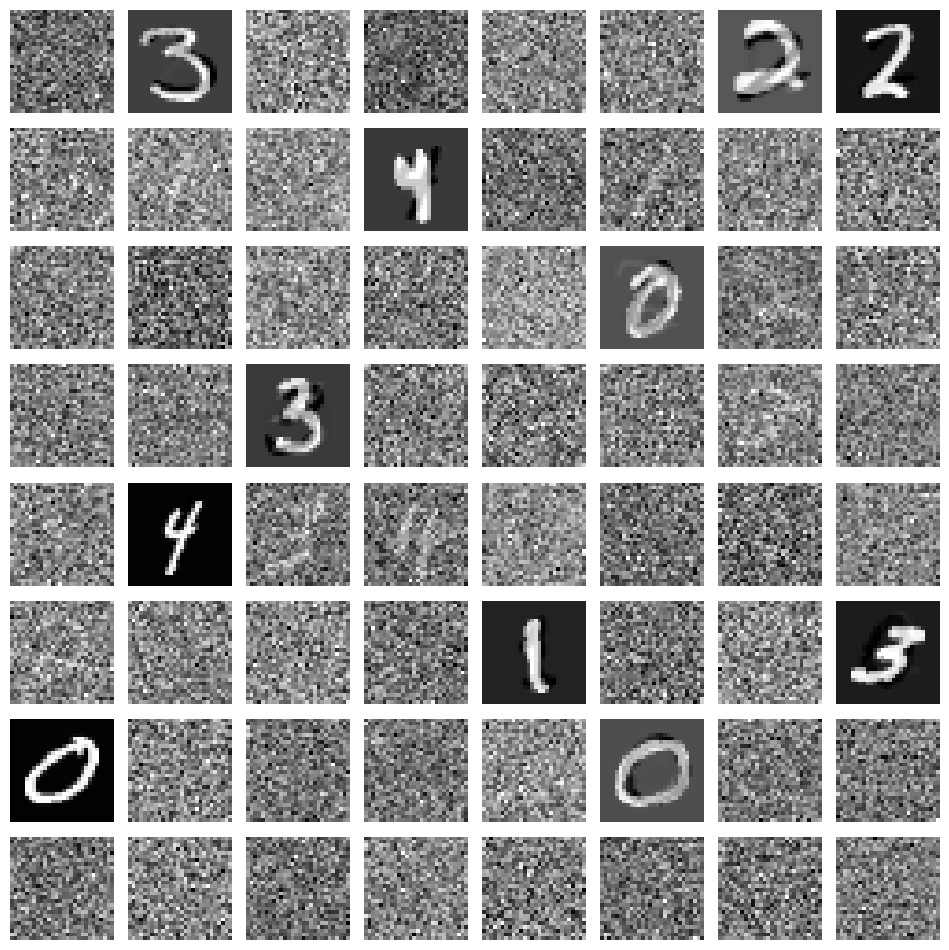

In [130]:
# look at the hebbian weights as images.

plot_weight_vectors(net.W)

In [131]:
#  Evaluate a simple "majory label" approach: 
#  i) Every neuron gets a vote according to the input class it is most active for
# ii) For every input, every neuron votes for that class, majority wins.

unit_lbls = net.majority_labels(Xtr, ytr)
acc       = net.accuracy(Xte, yte, unit_lbls)

print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.689


In [132]:
# Alternatively, evaluate a simple linear classifier on the features learned by the hebb algorith,.

net.train_linear_classifier(Xtr, ytr)
acc_lc = net.linear_accuracy(Xte, yte)

print(f"Test accuracy: {acc_lc:.3f}")

Test accuracy: 0.940


### Experiments

1. hebbian learning
2. hebbian learning, WTA
3. hebbian learning, WTA, weight normalization
4. Oja's rule 

I suspect the later experiments being better then the earlier once.So just accuracy based: 4 > 3 > 2 > 1. 

I expect the biggest improvement between WTA with and without weight normalization. This is because of the problem of run away weight vectors for hebbian learning. 

### Results

- As expected is hebbian learning without weight norm quite bad, only achieving an accurayc of around 0.18, while using weigh norm it ahcieve around 0.94, a huge imporvement.
- Suprisingly enough, does Oja's rule also massivly improving given weight norm. From 0.23 to 0.93. Here hebbian still wins out, which is also contra to the expectations.
- Hebbian produces signifantly better results for the majority label classifer the ojas rule, 0.78 vs 0.67
- funnily enough, without norm, but with WTA ojas rule seems to perform the same as hebb for the linear classifer (0.193 vs 0.193)